# Title: Stock Price Prediction and Algorithm Trading
#### Objective: 
#### 1 - To predict stock price using various machine learning models and LSTM model. 
#### 2 - Using the predicted price, algorithm trading strategy is developed based on simple moving average (SMA) and Moving average convergence divergence (MACD)

#### Using the past 5 years of stock price information, including percentage change in price and volumes, this workbook develops various models to predict the stock price and forecast next day share price using the model with the highest accuracy score. Using SMA and MACD, the investing strategy is developed, providing recommendation to accumulate to sell. 

#### Results - Linear regression and Lasso regression performed the best in predicting the stock price based on the accuracy score. 

In [782]:
#Importing libraries
import pandas_datareader as web
import numpy as np
import pandas as pd

import seaborn as sns

# from datetime import date
import datetime

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
# plt.style.use('fivethirtyeight')

# libraries for various machine learning models
# Linear regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
# RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
# Gridsearch
from sklearn.model_selection import GridSearchCV
# Cross validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

# Colleting the data

In [783]:
#getting today's date
today = datetime.datetime.today().strftime('%Y-%m-%d')
print(today)
#getting last 5years worth of data
startdate = datetime.datetime.today() - datetime.timedelta(days=(365*5))
startdate = startdate.strftime('%Y-%m-%d')
# startdate = today.replace(year=today.year-3)
print(startdate)

2021-12-18
2016-12-19


In [784]:
# Insert the name of the stock
stock = 'WMT'

In [785]:
# get the stock quote
df = web.DataReader(stock, data_source='yahoo', start=startdate, 
                   end=today)

In [787]:
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-12-19,71.750000,70.839996,70.839996,71.580002,5889300.0,64.680016
2016-12-20,71.930000,71.510002,71.730003,71.820000,6108100.0,64.896889
2016-12-21,72.000000,71.239998,71.660004,71.239998,5101000.0,64.372795
2016-12-22,71.239998,69.209999,71.239998,69.589996,12106800.0,62.881836
2016-12-23,69.750000,69.360001,69.430000,69.540001,4803900.0,62.836666
...,...,...,...,...,...,...
2021-12-10,141.300003,137.570007,138.339996,141.029999,12855900.0,141.029999
2021-12-13,143.750000,140.009995,140.240005,143.570007,18013100.0,143.570007
2021-12-14,145.279999,142.149994,143.300003,144.940002,15573800.0,144.940002


In [ ]:
# save the data to csv file
df.to_csv("share_price.csv")

In [6]:
# this is for Google Colab
# Google colab is used for training LSTM model
# from google.colab import files
# uploaded = files.upload()
# import io
# df = pd.read_csv(io.BytesIO(uploaded['share_price.csv']), index_col='Date')
# # Dataset is now stored in a Pandas Dataframe


Saving share_price.csv to share_price.csv


In [788]:
df.index = pd.to_datetime(df.index)
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-12-19,71.750000,70.839996,70.839996,71.580002,5889300.0,64.680016
2016-12-20,71.930000,71.510002,71.730003,71.820000,6108100.0,64.896889
2016-12-21,72.000000,71.239998,71.660004,71.239998,5101000.0,64.372795
2016-12-22,71.239998,69.209999,71.239998,69.589996,12106800.0,62.881836
2016-12-23,69.750000,69.360001,69.430000,69.540001,4803900.0,62.836666
...,...,...,...,...,...,...
2021-12-10,141.300003,137.570007,138.339996,141.029999,12855900.0,141.029999
2021-12-13,143.750000,140.009995,140.240005,143.570007,18013100.0,143.570007
2021-12-14,145.279999,142.149994,143.300003,144.940002,15573800.0,144.940002


In [789]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2016-12-19 to 2021-12-16
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       1258 non-null   float64
 1   Low        1258 non-null   float64
 2   Open       1258 non-null   float64
 3   Close      1258 non-null   float64
 4   Volume     1258 non-null   float64
 5   Adj Close  1258 non-null   float64
dtypes: float64(6)
memory usage: 68.8 KB


In [790]:
# function for percentage change
# percentage change ((t - t_1)/(t_1))*100
def perc_chg(data, column_name): 
    data[f'perc_chg_{column_name}'] = ((data[column_name]-data[column_name].shift(1))/(data[column_name].shift(1))*100)

In [791]:
# percentage change for Adj Close
perc_chg(df, 'Adj Close')
# percentage change for Volumes
perc_chg(df, 'Volume')

# excluding the first date as there will be missing data
df = df[1:]
df

,High,Low,Open,Close,Volume,Adj Close,perc_chg_Adj Close,perc_chg_Volume
Date,,,,,,,,
2016-12-20,71.930000,71.510002,71.730003,71.820000,6108100.0,64.896889,0.335302,3.715212
2016-12-21,72.000000,71.239998,71.660004,71.239998,5101000.0,64.372795,-0.807579,-16.487942
2016-12-22,71.239998,69.209999,71.239998,69.589996,12106800.0,62.881836,-2.316132,137.341698
2016-12-23,69.750000,69.360001,69.430000,69.540001,4803900.0,62.836666,-0.071833,-60.320646
2016-12-27,69.820000,69.250000,69.300003,69.699997,4435700.0,62.981228,0.230060,-7.664606
...,...,...,...,...,...,...,...,...
2021-12-10,141.300003,137.570007,138.339996,141.029999,12855900.0,141.029999,1.826714,19.213828
2021-12-13,143.750000,140.009995,140.240005,143.570007,18013100.0,143.570007,1.801041,40.115433
2021-12-14,145.279999,142.149994,143.300003,144.940002,15573800.0,144.940002,0.954235,-13.541811


In [794]:
# Selecting the features 
features = ['Adj Close','Volume','perc_chg_Adj Close','perc_chg_Volume']
data = df[features]
# show the data
data.head()

,Adj Close,Volume,perc_chg_Adj Close,perc_chg_Volume
Date,,,,
2016-12-20,64.896889,6108100.0,0.335302,3.715212
2016-12-21,64.372795,5101000.0,-0.807579,-16.487942
2016-12-22,62.881836,12106800.0,-2.316132,137.341698
2016-12-23,62.836666,4803900.0,-0.071833,-60.320646
2016-12-27,62.981228,4435700.0,0.230060,-7.664606


# EDA and Visualisation

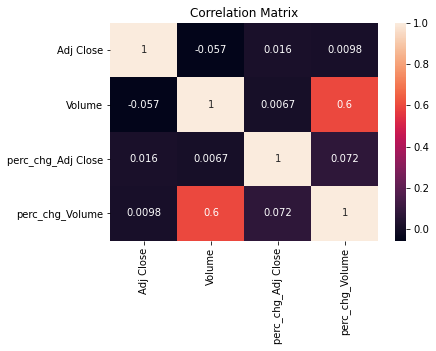

In [795]:
# correlation matrix
sns.heatmap(data.corr(), annot=True)
plt.title('Correlation Matrix')
plt.show()

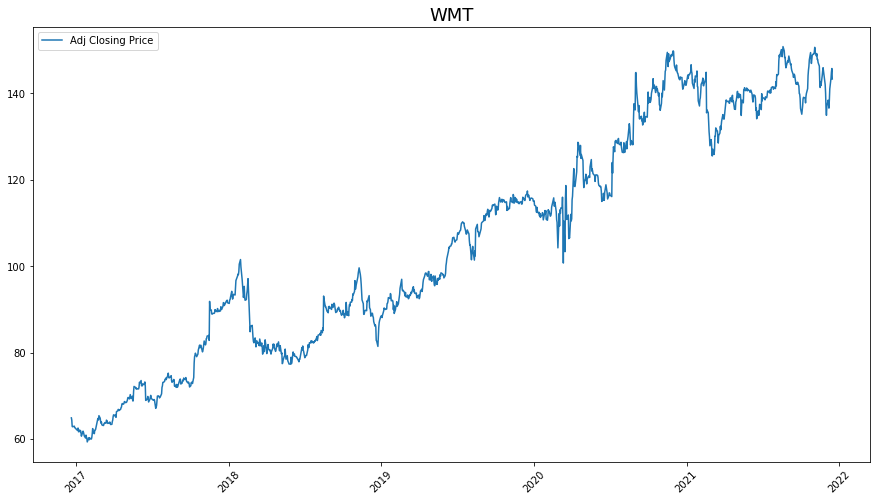

In [796]:
# plot the share price
plt.figure(figsize=(15,8))
plt.plot(data['Adj Close'], label='Adj Closing Price')
plt.xticks(rotation=45)
plt.title(stock, size=18)
plt.legend()

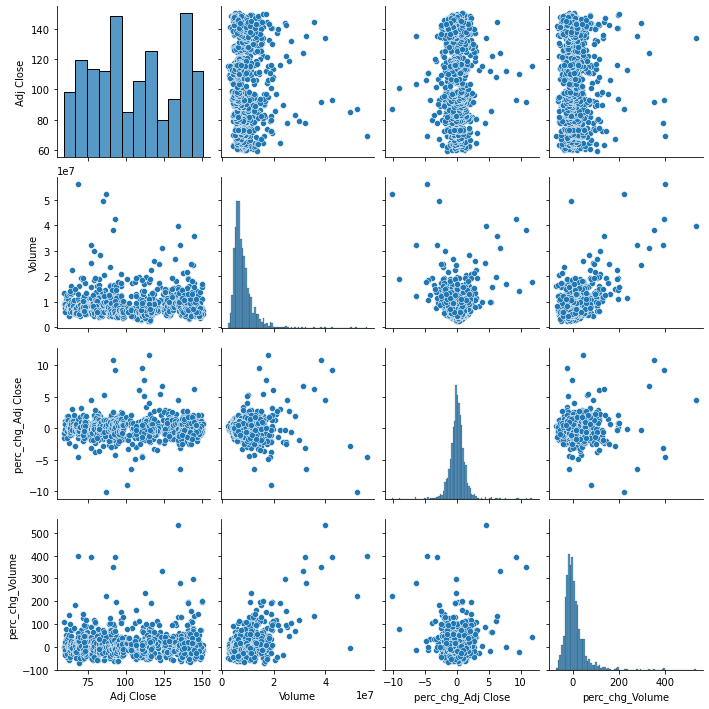

In [797]:
# pairplot to visualise the distribution
sns.pairplot(data)

# Data for machine learning models

In [798]:
# creating a new dataset for machine learning models 
data1 = data.copy()
# creating a y variable 
# prediction variable which is the t+1 price
data1['Prediction'] = data1[['Adj Close']].shift(-1)
data1

,Adj Close,Volume,perc_chg_Adj Close,perc_chg_Volume,Prediction
Date,,,,,
2016-12-20,64.896889,6108100.0,0.335302,3.715212,64.372795
2016-12-21,64.372795,5101000.0,-0.807579,-16.487942,62.881836
2016-12-22,62.881836,12106800.0,-2.316132,137.341698,62.836666
2016-12-23,62.836666,4803900.0,-0.071833,-60.320646,62.981228
2016-12-27,62.981228,4435700.0,0.230060,-7.664606,62.628830
...,...,...,...,...,...
2021-12-10,141.029999,12855900.0,1.826714,19.213828,143.570007
2021-12-13,143.570007,18013100.0,1.801041,40.115433,144.940002
2021-12-14,144.940002,15573800.0,0.954235,-13.541811,145.770004


### Generating training and test dataset for ML 

In [799]:
# generating training and test dataset
# naming X and Y feature names
y_feature = 'Prediction' # column name for y
X_features = [names for names in data1.columns if names!=y_feature]
X_features

# creating X and Y 
# X dataset
ml_X = data1[X_features]
# y dataset
ml_y = data1[y_feature]

# dataset excluding the last row for predicting the price tomorrow 
ml_X1 = ml_X[:-1] # X dataset excluding the last row
ml_y1 = ml_y[:-1] # y dataset excluding the last row

# last row for prediction
last_row = ml_X.iloc[[-1]]

# creating training and test dataset (80 - 20 split)
train_index = int(np.round(ml_X1.shape[0]*0.8,0))

# Training dataset
ml_X_train = ml_X1.iloc[:train_index] # X_train
ml_y_train = ml_y1.iloc[:train_index] # y_train
# Test dataset
ml_X_test = ml_X1.iloc[train_index:] # X_test
ml_y_test = ml_y1.iloc[train_index:] # y_test

print("X dataset shape\n Training Dataset shape: ", ml_X_train.shape, "\n Test Dataset Shape: ", ml_X_test.shape)
print("Y dataset shape\n Training Dataset shape: ", ml_y_train.shape, "\n Test Dataset Shape: ", ml_y_test.shape)

X dataset shape
 Training Dataset shape:  (1005, 4) 
 Test Dataset Shape:  (251, 4)
Y dataset shape
 Training Dataset shape:  (1005,) 
 Test Dataset Shape:  (251,)


# Feature scaling

In [800]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
# scaled training dataset
scaled_ml_X_train = scaler.fit_transform(ml_X_train)
# scaled test dataset
scaled_ml_X_test = scaler.transform(ml_X_test)

# Various Machine Learning

In [801]:
# to create dataframe with predicted price
df_pred_price = pd.DataFrame(ml_y_test)
df_pred_price = df_pred_price.rename(columns={"Prediction": "Actual price"})

Grid search for Random Forest is done first as all models will be iterated in the for loop. Based on the various parameters tested for Random Forest, the best parameters are used.

In [802]:
# Create the parameter grid based on the results of random search 
param_grid = {
    # 'bootstrap': [True],
    'max_depth': [10, 50, 80, 90, 100, 110],
    # 'max_features': [2, 3],
    # 'min_samples_leaf': [3, 4, 5],
    # 'min_samples_split': [8, 10, 12],
    'n_estimators': [10, 50, 100, 200, 300]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
# model fit
grid_search.fit(scaled_ml_X_train, ml_y_train)
# best parameters
print(grid_search.best_params_)
# best score
print(grid_search.best_score_)


Fitting 3 folds for each of 30 candidates, totalling 90 fits
{'max_depth': 110, 'n_estimators': 10}
0.005357747049921313


In [803]:
# lists of all models used. 
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
models.append(('RF', RandomForestRegressor(max_depth=grid_search.best_params_['max_depth'], n_estimators=grid_search.best_params_['n_estimators'])))

# generating empty lists
train_scores = []
test_scores = []
cv_train_scores = []
cv_test_scores = []
price_tomorrow = []

# function for model fit and storing the scores in the dataframe.
def ml_models(names, model_name, X_train, y_train, X_test, y_test):
    # define model
    model = model_name
    # model fit
    model.fit(X_train, y_train)
    # model score
    model_train_score = model.score(X_train, y_train)
    model_test_score = model.score(X_test, y_test)
    # CV scores 
    cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
    # CV scores - train
    cv_train_score = cross_val_score(model, X_train, y_train, cv=cv)
    cv_train_score = cv_train_score.mean()
    # CV scores - test
    cv_test_score = cross_val_score(model, X_test, y_test, cv=cv)
    cv_test_score = cv_test_score.mean()

    # prediction
    model_pred = model.predict(X_test)
    model_tmr_price = model.predict(scaler.transform(last_row))[0]
    # putting them all together
    train_scores.append(model_train_score)
    test_scores.append(model_test_score)
    cv_train_scores.append(cv_train_score)
    cv_test_scores.append(cv_test_score)
    price_tomorrow.append(model_tmr_price)
    df_pred_price[names] = model_pred

In [804]:
# running all models
# all models
for names, model_names in models:
    ml_models(names, model_names, scaled_ml_X_train, ml_y_train, scaled_ml_X_test, ml_y_test)


In [805]:
# putting all the scores into a DataFrame
df_results = pd.DataFrame(models, columns=['Model names','models'])
df_results['Train Scores'] = train_scores
df_results['Test Scores'] = test_scores
df_results['CV_Train Scores'] = cv_train_scores
df_results['CV_Test Scores'] = cv_test_scores
df_results['Price tomorrow'] = price_tomorrow
df_results

,Model names,models,Train Scores,Test Scores,CV_Train Scores,CV_Test Scores,Price tomorrow
0,LR,LinearRegression(),0.995642,0.922379,0.995499,0.907703,143.579089
1,LASSO,Lasso(),0.961044,-1.488467,0.960655,-0.035763,134.702856
2,EN,ElasticNet(),0.182549,-56.598595,0.174614,-0.035763,101.285084
3,KNN,KNeighborsRegressor(),0.992736,0.768250,0.988063,0.824946,142.257785
4,CART,DecisionTreeRegressor(),1.000000,0.819873,0.990538,0.794053,143.301163
5,SVR,SVR(),0.978095,-0.490246,0.974862,0.631804,137.680087
6,RF,"(DecisionTreeRegressor(max_depth=110, max_feat...",0.999011,0.895372,0.994150,0.867965,142.428282


In [806]:
# best models sorted
df_results_top2 = list(df_results.sort_values(by='Test Scores', ascending=False)['Model names'][:2])
# keeping the price of the best prediction model 
ml_best_price = df_results.sort_values(by='Test Scores', ascending=False)['Price tomorrow'][0]
ml_best_price

143.5790888036525

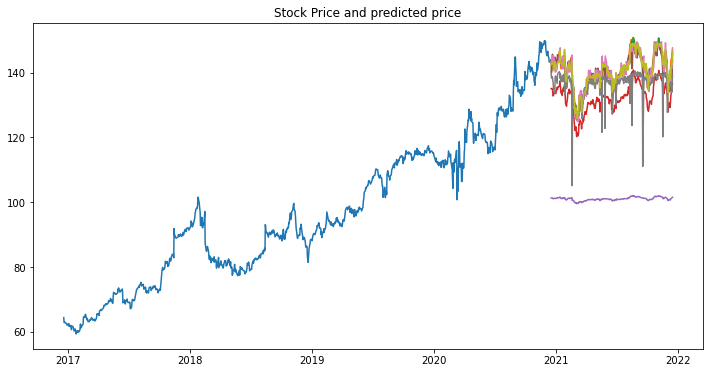

In [807]:
# plotting the stock price
plt.figure(figsize=(12,6))
plt.plot(ml_y_train)
plt.plot(df_pred_price)
plt.title("Stock Price and predicted price")
plt.show()

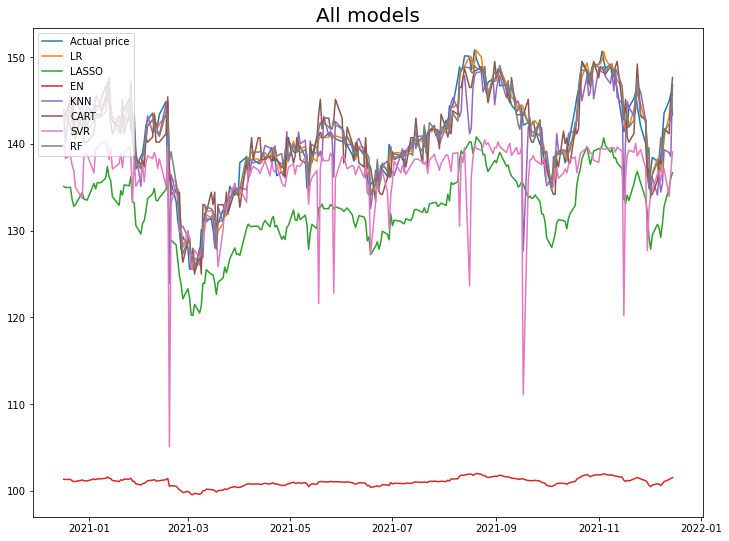

In [808]:
# visualise the top accurate models
label_name = df_pred_price.columns
plt.figure(figsize=(12,9))
plt.plot(df_pred_price, label= label_name)
plt.legend(loc='upper left')
plt.title("All models", size=20)
plt.show()

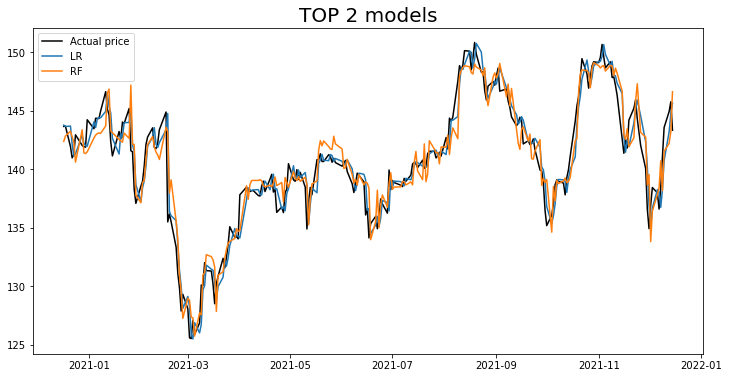

In [809]:
plt.figure(figsize=(12,6))
plt.plot(df_pred_price['Actual price'], color='black', label = 'Actual price')
plt.plot(df_pred_price[df_results_top2], label = df_results_top2)
plt.legend()
plt.title("TOP 2 models", size=20)
plt.show()

# Algorithmic Trading
### 1. MACD
### 2. Simple Moving Average (SMA)

In [810]:
# creating a new dataframe for trading
data_for_trading = data[['Adj Close']]
# adding additional row for new prediction price (based on highest test scores)
next_day = data_for_trading.index[-1] + datetime.timedelta(days=1)
data_for_trading = data_for_trading.append(pd.Series(name = next_day, dtype='float64'))
# adding the new predicted price 
data_for_trading['Adj Close'][-1] = ml_best_price

## MACD

In [811]:
# Calculate the MACD and signal line indicators
#calculate the short term exponential moving average (EMA)
shortEMA = data_for_trading['Adj Close'].ewm(span=12, adjust=False).mean()
#Calculate the long term EMA
longEMA = data_for_trading['Adj Close'].ewm(span=26, adjust=False).mean()
#Calculate the MACD line
MACD = shortEMA - longEMA
#calculate the signal line
signal = MACD.ewm(span=9, adjust=False).mean()

# adding the MACD and signal line to the dataframe
data_for_trading['MACD'] = MACD
data_for_trading['signal'] = signal


## Simple Moving Average (SMA)

In [812]:
SMA_short_window = 20
SMA_long_window = 100
# SMA for smaller window
data_for_trading["SMA_short"] = data_for_trading['Adj Close'].rolling(window=SMA_short_window).mean()
# SMA for longer window
data_for_trading["SMA_long"] = data_for_trading['Adj Close'].rolling(window=SMA_long_window).mean()


In [813]:
#Create a function to signal when to buy and sell the stock
def buy_sell(data, actual_price, first_var, second_var): 
    Buy = []
    Sell = []
    flag = -1

    for i in range(len(data)):
        if data[first_var][i] > data[second_var][i]:
            if flag !=1:
                Buy.append(data[actual_price][i])
                Sell.append(np.nan)
                flag = 1 
            else: 
                Buy.append(np.nan)
                Sell.append(np.nan)
        elif data[first_var][i] < data[second_var][i]:
            if flag !=0: 
                Buy.append(np.nan)
                Sell.append(data[actual_price][i])
                flag = 0
            else: 
                Buy.append(np.nan)
                Sell.append(np.nan)
        else:
            Buy.append(np.nan)
            Sell.append(np.nan)
            
    return (Buy, Sell)



In [814]:
# for MACD
MACD_buy, MACD_sell = buy_sell(data_for_trading, 'Adj Close', 'MACD', 'signal')
# adding to the dataframe
data_for_trading['MACD_buy'] = MACD_buy
data_for_trading['MACD_sell'] = MACD_sell

In [815]:
# for SMA
SMA_buy, SMA_sell = buy_sell(data_for_trading, 'Adj Close', 'SMA_short', 'SMA_long')
# adding them to the dataframe
data_for_trading['SMA_buy'] = SMA_buy
data_for_trading['SMA_sell'] = SMA_sell

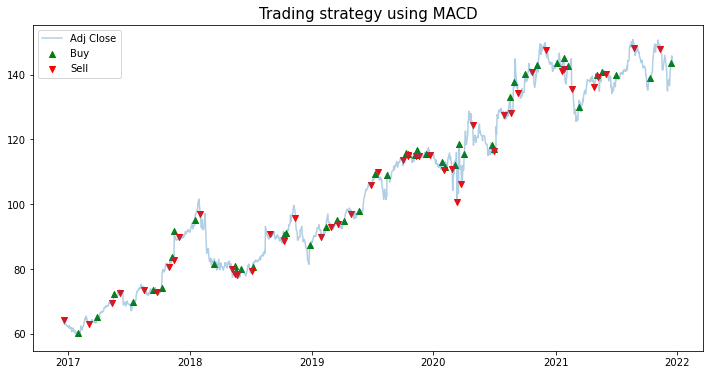

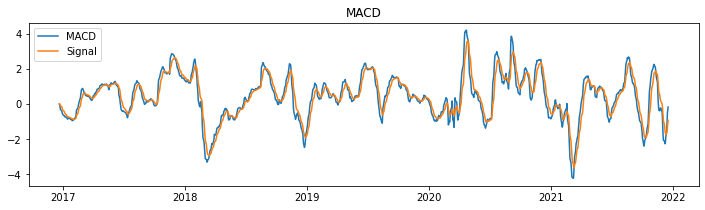

In [816]:
# visualise the data and the strategy to buy and sell the stock
plt.figure(figsize=(12, 6))
plt.plot(data_for_trading['Adj Close'], label = 'Adj Close', alpha=0.35)
plt.scatter(data_for_trading.index, data_for_trading['MACD_buy'], label = 'Buy', marker = '^', color = 'green')
plt.scatter(data_for_trading.index, data_for_trading['MACD_sell'], label = 'Sell', marker = 'v', color = 'red')
plt.legend(loc='upper left')
plt.title('Trading strategy using MACD', size=15)

#Visualize the data
plt.figure(figsize=(12,3))
# plt.plot(data_for_trading['Adj Close'], label = stock)
plt.plot(data_for_trading['MACD'], label = 'MACD')
plt.plot(data_for_trading['signal'], label = 'Signal')
plt.legend(loc='upper left')
plt.title('MACD')
plt.show()

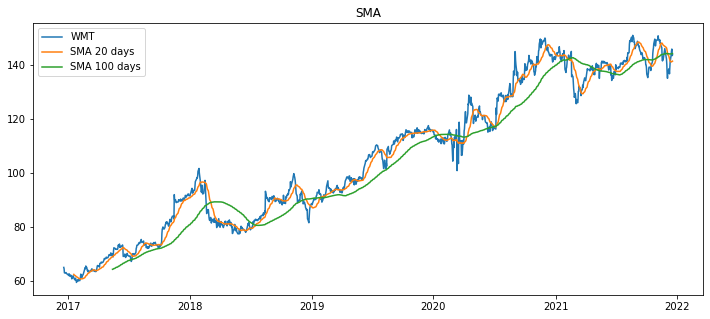

In [817]:
# Visualize the data
plt.figure(figsize=(12,5))
plt.plot(data_for_trading['Adj Close'], label = stock)
plt.plot(data_for_trading['SMA_short'], label = f'SMA {SMA_short_window} days')
plt.plot(data_for_trading['SMA_long'], label = f'SMA {SMA_long_window} days')
plt.legend(loc='upper left')
plt.title('SMA')
plt.show()

Text(0.5, 1.0, 'Trading strategy using SMA')

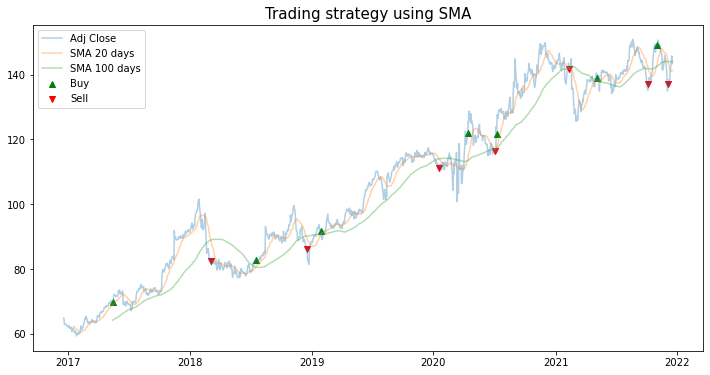

In [818]:
# visualise the data and the strategy to buy and sell the stock
plt.figure(figsize=(12, 6))
plt.plot(data_for_trading['Adj Close'], label = 'Adj Close', alpha=0.35)
plt.plot(data_for_trading['SMA_short'], label = f'SMA {SMA_short_window} days', alpha=0.35)
plt.plot(data_for_trading['SMA_long'], label = f'SMA {SMA_long_window} days', alpha=0.35)
plt.scatter(data_for_trading.index, data_for_trading['SMA_buy'], label = 'Buy', marker = '^', color = 'green')
plt.scatter(data_for_trading.index, data_for_trading['SMA_sell'], label = 'Sell', marker = 'v', color = 'red')
plt.legend(loc='upper left')
plt.title('Trading strategy using SMA', size = 15)



In [819]:
# accumulate or sell based on SMA
if data_for_trading['SMA_short'][-1] > data_for_trading['SMA_long'][-1]:
    print('SMA: Accumulate')
else:
    print('SMA: Sell')

# accumulate or sell based on MACD
if data_for_trading['MACD'][-1] > data_for_trading['signal'][-1]:
    print('MACD: Accumulate')
else:
    print('MACD: Sell')

SMA: Sell
MACD: Accumulate


# LSTM

In [48]:
#Import lib
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf


In [49]:
data_X_LSTM = ml_X.values
# MinMaxScaler
scaler1 = MinMaxScaler(feature_range=(0,1))
scaled_data_X_LSTM = scaler1.fit_transform(data_X_LSTM)
print(scaled_data_X_LSTM.shape)
# y dataset
data_y_LSTM = ml_y.values
data_y_LSTM

(1257, 4)


array([ 64.37277985,  62.88182449,  62.8366394 , ..., 145.77000427,
       143.33999634,          nan])

In [50]:
#creating training dataset
# based on different number of days
def LSTM_train_test(days, data_X, data_y):
    X_train = []
    y_train = []
    
    for i in range(days, len(data_X)): 
        X_train.append(data_X[i-days:i, :])
        y_train.append(data_y[i])
    
    X_train, y_train = np.array(X_train), np.array(y_train)

    # keeping the last row separate
    last_row = X_train[-1]
    X_train = X_train[:-1] # removing the last row for prediction
    
    y_train = np.reshape(y_train, (y_train.shape[0],1))
    y_train = y_train[:-1] #removing the last row as it is missing
    
    print("X",  str(days), ": ", str(X_train.shape))
    print("y",  str(days), ": ", str(y_train.shape))
    
    # creating a test dataset
    # training data length 80/20 split
    len_for_test_LSTM = int(np.round(len(X_train)*0.8))
    # Test set
    X_test = X_train[len_for_test_LSTM:]
    y_test = y_train[len_for_test_LSTM:]
    print("X_test",  str(days), ": ", X_test.shape)
    print("y_test",  str(days), ": ", y_test.shape)
    # redefine Train set
    X_train = X_train[:len_for_test_LSTM]
    y_train = y_train[:len_for_test_LSTM]
    print("X_train",  str(days), ": ", X_train.shape)
    print("y_train",  str(days), ": ", y_train.shape)

    return X_train, y_train, X_test, y_test, last_row


In [80]:
# 20 days
X_train_LSTM_20, y_train_LSTM_20, X_test_LSTM_20, y_test_LSTM_20, last_row_LSTM_20 = LSTM_train_test(
    21, scaled_data_X_LSTM, data_y_LSTM)
# 14 days
X_train_LSTM_14, y_train_LSTM_14, X_test_LSTM_14, y_test_LSTM_14, last_row_LSTM_14 = LSTM_train_test(
    14, scaled_data_X_LSTM, data_y_LSTM)
# 7 days
X_train_LSTM_7, y_train_LSTM_7, X_test_LSTM_7, y_test_LSTM_7, last_row_LSTM_7 = LSTM_train_test(
    7, scaled_data_X_LSTM, data_y_LSTM)

X 21 :  (1235, 21, 4)
y 21 :  (1235, 1)
X_test 21 :  (247, 21, 4)
y_test 21 :  (247, 1)
X_train 21 :  (988, 21, 4)
y_train 21 :  (988, 1)
X 14 :  (1242, 14, 4)
y 14 :  (1242, 1)
X_test 14 :  (248, 14, 4)
y_test 14 :  (248, 1)
X_train 14 :  (994, 14, 4)
y_train 14 :  (994, 1)
X 7 :  (1249, 7, 4)
y 7 :  (1249, 1)
X_test 7 :  (250, 7, 4)
y_test 7 :  (250, 1)
X_train 7 :  (999, 7, 4)
y_train 7 :  (999, 1)


In [52]:
# Building a model
def model_LSTM(x_train):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    #Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    
    return model

In [53]:
model_LSTM_20 = model_LSTM(X_train_LSTM_20)
model_LSTM_14 = model_LSTM(X_train_LSTM_14)
model_LSTM_7 = model_LSTM(X_train_LSTM_7)

In [55]:
%%time 
#fit the model
# LSTM 20days
model_LSTM_20.fit(X_train_LSTM_20, y_train_LSTM_20, batch_size=1, epochs=35, verbose=0)
# LSTM 14days
model_LSTM_14.fit(X_train_LSTM_14, y_train_LSTM_14, batch_size=1, epochs=35, verbose=0)
# LSTM 7days
model_LSTM_7.fit(X_train_LSTM_7, y_train_LSTM_7, batch_size=1, epochs=35, verbose=0)


CPU times: user 22min 35s, sys: 1min 19s, total: 23min 54s
Wall time: 14min 25s


In [88]:
# # saving the models for later if needed
# model_LSTM_20.save("./checkpoints/model_LSTM_20.h5")
# model_LSTM_14.save("./checkpoints/model_LSTM_14.h5")
# model_LSTM_7.save("./checkpoints/model_LSTM_7.h5")

In [56]:
# predictions
# 20 days
pred_LSTM_20 = model_LSTM_20.predict(X_test_LSTM_20)
# 14 days
pred_LSTM_14 = model_LSTM_14.predict(X_test_LSTM_14)
# 7 days
pred_LSTM_7 = model_LSTM_7.predict(X_test_LSTM_7)

In [58]:
# creating DataFrame for plotting
# 20 days
df_LSTM_plot_20 = ml_X[['Adj Close']][len(ml_X)-len(X_test_LSTM_20)-1 : -1]
df_LSTM_plot_20['LSTM_pred_price'] = pred_LSTM_20
print(df_LSTM_plot_20.shape)
# 14 days
df_LSTM_plot_14 = ml_X[['Adj Close']][len(ml_X)-len(X_test_LSTM_14)-1 : -1]
df_LSTM_plot_14['LSTM_pred_price'] = pred_LSTM_14
print(df_LSTM_plot_14.shape)
# 7 days
df_LSTM_plot_7 = ml_X[['Adj Close']][len(ml_X)-len(X_test_LSTM_7)-1 : -1]
df_LSTM_plot_7['LSTM_pred_price'] = pred_LSTM_7
print(df_LSTM_plot_7.shape)

(247, 2)
(248, 2)
(250, 2)


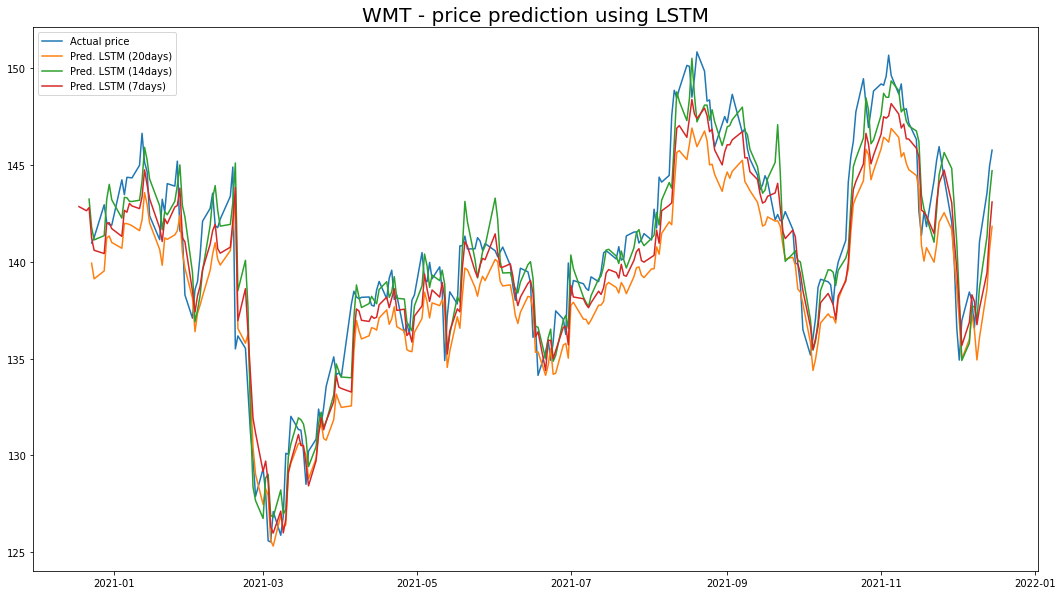

In [62]:
# plotting all 3 models
plt.figure(figsize=(18,10))
plt.plot(df_LSTM_plot_20['Adj Close'], label = 'Actual price')
plt.plot(df_LSTM_plot_20['LSTM_pred_price'], label = 'Pred. LSTM (20days)')
plt.plot(df_LSTM_plot_14['LSTM_pred_price'], label = 'Pred. LSTM (14days)')
plt.plot(df_LSTM_plot_7['LSTM_pred_price'], label = 'Pred. LSTM (7days)')
plt.legend()
plt.title(f'{stock} - price prediction using LSTM', size=20)
plt.show()

In [81]:
# function for reshaping the new data
def last_row_reshape(last_row): 
  last_row = last_row.reshape(1,last_row.shape[0],last_row.shape[1])
  return last_row
# reshaping to fit the model 
# LSTM 20days
last_row_LSTM_20 = last_row_reshape(last_row_LSTM_20)
# LSTM 14days
last_row_LSTM_14 = last_row_reshape(last_row_LSTM_14)
# LSTM 7days
last_row_LSTM_7 = last_row_reshape(last_row_LSTM_7)


In [86]:
#predict the tomorrow price
# 20 days
price_tomorrow_LSTM_20 = model_LSTM_20.predict(last_row_LSTM_20)[0][0]
# 14 days
price_tomorrow_LSTM_14 = model_LSTM_14.predict(last_row_LSTM_14)[0][0]
# 7 days
price_tomorrow_LSTM_7 = model_LSTM_7.predict(last_row_LSTM_7)[0][0]

# print the price
print('Price for tomorrow (LSTM 20 days) is $',price_tomorrow_LSTM_20)
print('Price for tomorrow (LSTM 14 days) is $',price_tomorrow_LSTM_14)
print('Price for tomorrow (LSTM 7 days) is $',price_tomorrow_LSTM_7)

Price for tomorrow (LSTM 20 days) is $ 142.37663
Price for tomorrow (LSTM 14 days) is $ 145.09615
Price for tomorrow (LSTM 7 days) is $ 143.67017
